In [2]:
from abc import ABC, abstractmethod

class ITextToImageGenerator(ABC):
    @abstractmethod
    def process(prompt: str, **kwargs):
        pass

In [3]:
from typing import Optional, Type


class TextToImageGeneratorFactory:
    default_strategy = "sdxl-turbo"
    strategy_map: dict[str, Type[ITextToImageGenerator]] = {}

    @classmethod
    def register(cls, name: str, generator_cls: Optional[ITextToImageGenerator]):
        if not issubclass(generator_cls, ITextToImageGenerator):
            raise TypeError(
                f"{generator_cls} must inherit from ITextToImageGenerator")
        cls.strategy_map[name] = generator_cls

    @classmethod
    def create(cls, name: str, **kwargs) -> ITextToImageGenerator:
        name = name or cls.default_strategy
        generator_cls = cls.strategy_map.get(name)
        if generator_cls is None:
            raise TypeError(f"No generator registered with name '{name}'")
        return generator_cls(**kwargs)


In [4]:
from typing import List, Optional

import torch
from diffusers import AutoPipelineForText2Image
from PIL import Image


class SDXLTurboGenerator(ITextToImageGenerator):
    def __init__(
        self,
        model_path: str = "stabilityai/sdxl-turbo",
        guidance_scale: float = 0.0,
        num_inference_steps: int = 4,
        device: str = "cuda",
        seed: int = 42,
        lora_path: Optional[str] = None,
    ):
        self.model_path = model_path
        self.guidance_scale = guidance_scale
        self.num_inference_steps = num_inference_steps
        self.device = device
        self.seed = seed
        self.lora_path = lora_path
        self.pipe = self._load_pipeline()

    def _load_pipeline(self):
        try:
            pipe = AutoPipelineForText2Image.from_pretrained(
                self.model_path, torch_dtype=torch.float16, variant="fp16"
            ).to(self.device)
            return pipe
        except Exception as e:
            raise ValueError(f"Failed to load pipeline: {e}") from e

    def process(
        self,
        prompt,
        num_images: int = 3,
        negative_prompt: str = "",
        height: int = 512,
        width: int = 512,
        **kwargs,
    ) -> List[Image.Image]:
        try:
            generator = torch.Generator("cuda")
            if self.seed is not None:
                generator.manual_seed(self.seed)

            outputs = self.pipe(
                prompt=prompt,
                num_images_per_prompt=num_images,
                negative_prompt=negative_prompt,
                height=height,
                width=width,
                num_inference_steps=self.num_inference_steps,
                guidance_scale=self.guidance_scale,
                generator=generator
            )
            return outputs.images
        except Exception as e:
            raise RuntimeError(f"Error in process(): {e}") from e


/home/anhndt/.conda/envs/pysvgenius/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import yaml
with open("../config/model_config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

gen_cfg = cfg["generator"]["sdxl-turbo"]
gen_cfg

{'model_path': 'stabilityai/sdxl-turbo',
 'guidance_scale': 0.0,
 'num_inference_steps': 1,
 'device': 'cuda',
 'seed': 1,
 'lora_path': None}

In [6]:
TextToImageGeneratorFactory.register("turbo", SDXLTurboGenerator)

In [7]:
generator = TextToImageGeneratorFactory.create("turbo", **gen_cfg)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


In [8]:
image = generator.process("flat color illustration, a lighthouse overlooking the ocean, inspired by Tom Whalen, vibrant palette, bold outlines, simple shapes, app icon.", num_images=3, height=512, width=512)

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


In [9]:
from IPython.display import display

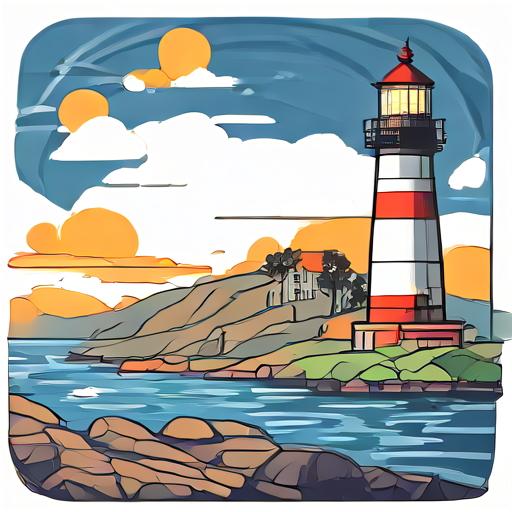

In [13]:
display(image[2])

In [11]:
image[1].save("raw_image.png", format="PNG")